# Project 3 - Part 2
For this phase of the project, you will be helping Chicago law enforcement allocate resources for the next 6 months.
## For each of your selected crimes, perform the following steps to develop a forecast.

- Transform the data to obtain a time series of the crime count per month using .size().
- Check for and address null values.
- Decompose the Time series to detect seasonality and decide whether to use a seasonal model or not
- Determine if nonseasonal and/or seasonal differencing is required
- Use the ACF and PACF plots of stationarity data to estimate initial orders
- Split the time series into training and test data (Remember we want to predict 6 months)
- Fit a manual ARIMA/SARIMA model based on the orders determined during your exploration.
    - Make forecasts with your model.
    - Plot the forecasts versus the test data
    - Obtain metrics for evaluation
- Tune with pmdarima's auto_arima
    - Fit a model on training data with the best parameters from auto_arima
    - Obtain metrics for evaluation
    - Make forecasts with the auto_arima model
    - Plot the forecasts versus the test data
- Select the final model and justify your choice. (Which metrics or diagnostics support your choice?)
- Make true future forecasts using the entire dataset (for dates beyond the entire ts)
## For each of your two selected crimes, answer the following questions in a markdown cell:

- Calculate the predicted net change in the number (raw counts) of this type of crime from the beginning of the forecast to the end.
- Convert the raw delta into a percent change.
## Final Evaluation:

After completing both models and getting the forecasts for both crimes for 6 months into the future (beyond the data), answer the following questions in a Markdown cell:

- Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?
- Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?
- Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?
## Final Recommendations

- What recommendation would you make to the stakeholders?
- Include reporting-quality visual(s) to support your recommendation.

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
import pmdarima as pm
#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
## Setting figures to timeseries-friendly
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['agg.path.chunksize'] = 1000
sns.set_context("talk", font_scale=0.9)
# set random seed
SEED = 321
np.random.seed(SEED)
#display more columns
pd.set_option('display.max_columns',50)
## Customization Options

#import tick customization tools
import matplotlib.ticker as mticks
import matplotlib.dates as mdates
sns.set_context("talk", font_scale=0.9)

## Required Fns

In [2]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax


In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
### NEW FUNCTION FOR COMBINED ACF/PACF WITH ANNOTATIONS
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [6]:
def get_sig_lags(ts, type='ACF',  nlags=None,alpha=0.5):
    

    if type == 'ACF':
        # Running the function used by plot_acf
        corr_values, conf_int = tsa.stattools.acf(ts, alpha=alpha, nlags=nlags)
        
    elif type=='PACF':
        corr_values, conf_int = tsa.stattools.pacf(ts, alpha=alpha, nlags=nlags)
        
    else: 
        raise Exception("type must be either 'ACF' or 'PACF'")
        
    # Determine lags
    lags =range(len(corr_values))
    
    # Create a centered version of the acf_df 
    corr_df = pd.DataFrame({type:corr_values,
                            'Lags':lags,
                            'lower ci': conf_int[:,0]-corr_values, # subtract acf from lower ci to center
                            'upper ci': conf_int[:,1]-corr_values, # subtact acf to upper ci to center
                                 })
    corr_df = corr_df.set_index("Lags")
    
    # Getting filter for sig lags
    filter_sig_lags = (corr_df[type] < corr_df['lower ci']) | (corr_df[type] > corr_df['upper ci'])

    # Get lag #'s 
    sig_lags= corr_df.index[filter_sig_lags]
    sig_lags = sig_lags[sig_lags!=0]

    return sig_lags

## Loading Data

In [7]:
f = r'C:\Users\Lenovo\Downloads\Crimes_-_2001_to_Present_20240905.csv'
df = pd.read_csv(f)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8146404 entries, 0 to 8146403
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Case Number           object 
 2   Date                  object 
 3   Block                 object 
 4   IUCR                  object 
 5   Primary Type          object 
 6   Description           object 
 7   Location Description  object 
 8   Arrest                bool   
 9   Domestic              bool   
 10  Beat                  int64  
 11  District              float64
 12  Ward                  float64
 13  Community Area        float64
 14  FBI Code              object 
 15  X Coordinate          float64
 16  Y Coordinate          float64
 17  Year                  int64  
 18  Updated On            object 
 19  Latitude              float64
 20  Longitude             float64
 21  Location              object 
dtypes: bool(2), float64(7), int64(3), object(1

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,5741943,HN549294,08/25/2007 09:22:18 AM,074XX N ROGERS AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,2422,24.0,49.0,1.0,08A,NaN,NaN,2007,08/17/2015 03:03:40 PM,NaN,NaN,NaN
1,25953,JE240540,05/24/2021 03:06:00 PM,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,2515,25.0,36.0,19.0,01A,1141387.0,1913179.0,2021,11/18/2023 03:39:49 PM,41.917838,-87.755969,"(41.917838056, -87.755968972)"
2,26038,JE279849,06/26/2021 09:24:00 AM,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,1711,17.0,50.0,13.0,01A,1152781.0,1941458.0,2021,11/18/2023 03:39:49 PM,41.995219,-87.713355,"(41.995219444, -87.713354912)"
3,13279676,JG507211,11/09/2023 07:30:00 AM,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,1922,19.0,47.0,5.0,05,1162518.0,1925906.0,2023,11/18/2023 03:39:49 PM,41.952345,-87.677975,"(41.952345086, -87.677975059)"
4,13274752,JG501049,11/12/2023 07:59:00 AM,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,False,632,6.0,6.0,44.0,08B,1183071.0,1847869.0,2023,12/09/2023 03:41:24 PM,41.737751,-87.604856,"(41.737750767, -87.604855911)"


## Inspecting the data

In [8]:
df.duplicated().sum()

0

In [9]:
cols_to_drop = ['ID','Case Number','X Coordinate','Y Coordinate','Latitude','Longitude','Location']
df = df.drop(columns = cols_to_drop)

In [10]:
df.isna().sum()

Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description     13509
Arrest                       0
Domestic                     0
Beat                         0
District                    47
Ward                    614829
Community Area          613453
FBI Code                     0
Year                         0
Updated On                   0
dtype: int64

dropping some of the columns that has missing values

In [11]:
df = df.drop(columns = ['Community Area','Ward'])

In [12]:
df.isnull().sum() * 100 / len(df)

Date                    0.000000
Block                   0.000000
IUCR                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.165828
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.000577
FBI Code                0.000000
Year                    0.000000
Updated On              0.000000
dtype: float64

so we will impute the missing values but lets find the best approach

In [13]:
df.describe()

,Beat,District,Year
count,8.146404e+06,8.146357e+06,8.146404e+06
mean,1.184722e+03,1.129758e+01,2.010543e+03
std,7.035488e+02,6.959733e+00,6.722540e+00
min,1.110000e+02,1.000000e+00,2.001000e+03
25%,6.210000e+02,6.000000e+00,2.005000e+03
50%,1.034000e+03,1.000000e+01,2.009000e+03
75%,1.731000e+03,1.700000e+01,2.016000e+03
max,2.535000e+03,3.100000e+01,2.024000e+03


district will be imputed by backfilling

In [14]:
df['District'] = df['District'].fillna(method = 'bfill')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7420\2552773418.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['District'] = df['District'].fillna(method = 'bfill')


In [15]:
df.describe(include = ['O'])

,Date,Block,IUCR,Primary Type,Description,Location Description,FBI Code,Updated On
count,8146404,8146404,8146404,8146404,8146404,8132895,8146404,8146404
unique,3381290,64144,413,36,561,218,27,6479
top,01/01/2008 12:01:00 AM,100XX W OHARE ST,0820,THEFT,SIMPLE,STREET,06,02/10/2018 03:50:01 PM
freq,305,16749,657725,1723467,955932,2129276,1723548,2704249


so we will impute the missing values in location description by most frequent

In [17]:
df['Location Description'] = df['Location Description'].fillna(value = 'STREET')

In [18]:
df['Date'] = pd.to_datetime(df['Date'])

In [19]:
df = df.set_index('Date')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8146404 entries, 2007-08-25 09:22:18 to 2023-07-01 19:29:00
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Block                 object 
 1   IUCR                  object 
 2   Primary Type          object 
 3   Description           object 
 4   Location Description  object 
 5   Arrest                bool   
 6   Domestic              bool   
 7   Beat                  int64  
 8   District              float64
 9   FBI Code              object 
 10  Year                  int64  
 11  Updated On            object 
dtypes: bool(2), float64(1), int64(2), object(7)
memory usage: 699.2+ MB


In [21]:
df = df.sort_index()
df.index

DatetimeIndex(['2001-01-01 00:00:00', '2001-01-01 00:00:00',
               '2001-01-01 00:00:00', '2001-01-01 00:00:00',
               '2001-01-01 00:00:00', '2001-01-01 00:00:00',
               '2001-01-01 00:00:00', '2001-01-01 00:00:00',
               '2001-01-01 00:00:00', '2001-01-01 00:00:00',
               ...
               '2024-08-28 00:00:00', '2024-08-28 00:00:00',
               '2024-08-28 00:00:00', '2024-08-28 00:00:00',
               '2024-08-28 00:00:00', '2024-08-28 00:00:00',
               '2024-08-28 00:00:00', '2024-08-28 00:00:00',
               '2024-08-28 00:00:00', '2024-08-30 12:12:00'],
              dtype='datetime64[ns]', name='Date', length=8146404, freq=None)

In [22]:
cat_cols = df.select_dtypes(include = 'object')

In [23]:
for col in cat_cols:
    print(f"Value Counts for {col}")
    print(df[col].value_counts())
    # Increasing readability by adding an empty line
    print('\n')

Value Counts for Block
Block
100XX W OHARE ST           16749
001XX N STATE ST           16274
076XX S CICERO AVE         10474
0000X N STATE ST            9726
008XX N MICHIGAN AVE        9619
                           ...  
025XX N KENNEDY EXPY IB        1
000XX E 88TH ST                1
047XX N LAWLER AV              1
026XX W fletcher st            1
027XX N Artesian Ave           1
Name: count, Length: 64144, dtype: int64


Value Counts for IUCR
IUCR
0820    657725
0486    636342
0460    583613
0810    442357
1320    440155
         ...  
9901         1
1624         1
1633         1
1521         1
1518         1
Name: count, Length: 413, dtype: int64


Value Counts for Primary Type
Primary Type
THEFT                                1723467
BATTERY                              1485544
CRIMINAL DAMAGE                       927810
NARCOTICS                             755508
ASSAULT                               539209
OTHER OFFENSE                         505999
BURGLARY           

so there's inconsistent values in primary type

In [24]:
df['Primary Type'] = df['Primary Type'].replace({'NON-CRIMINAL (SUBJECT SPECIFIED)':"NON-CRIMINAL",'NON - CRIMINAL':'NON-CRIMINAL','CRIM SEXUAL ASSAULT':'CRIMINAL SEXUAL ASSAULT'})
df['Primary Type'].value_counts()

Primary Type
THEFT                                1723467
BATTERY                              1485544
CRIMINAL DAMAGE                       927810
NARCOTICS                             755508
ASSAULT                               539209
OTHER OFFENSE                         505999
BURGLARY                              434820
MOTOR VEHICLE THEFT                   410557
DECEPTIVE PRACTICE                    369176
ROBBERY                               306767
CRIMINAL TRESPASS                     220775
WEAPONS VIOLATION                     118081
PROSTITUTION                           70147
OFFENSE INVOLVING CHILDREN             58379
PUBLIC PEACE VIOLATION                 53618
CRIMINAL SEXUAL ASSAULT                36730
SEX OFFENSE                            32653
INTERFERENCE WITH PUBLIC OFFICER       19231
LIQUOR LAW VIOLATION                   15155
GAMBLING                               14643
ARSON                                  13950
HOMICIDE                               134

In [25]:
crime_list = df['Primary Type'].unique()
crime_list

array(['THEFT', 'CRIMINAL SEXUAL ASSAULT', 'SEX OFFENSE', 'OTHER OFFENSE',
       'DECEPTIVE PRACTICE', 'OFFENSE INVOLVING CHILDREN',
       'CRIMINAL DAMAGE', 'ASSAULT', 'BATTERY', 'BURGLARY',
       'MOTOR VEHICLE THEFT', 'WEAPONS VIOLATION', 'CRIMINAL TRESPASS',
       'ROBBERY', 'NARCOTICS', 'LIQUOR LAW VIOLATION',
       'PUBLIC PEACE VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER',
       'STALKING', 'HOMICIDE', 'GAMBLING', 'KIDNAPPING', 'PROSTITUTION',
       'INTIMIDATION', 'ARSON', 'RITUALISM', 'DOMESTIC VIOLENCE',
       'OBSCENITY', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY',
       'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL',
       'HUMAN TRAFFICKING'], dtype=object)

In [26]:
# 2. Create an empty dictionary  
CRIMES = {}
# 3. Loop through the list of crimes
for crime in crime_list:
    # I. Save a temp df of just the rows that match the crime
   temp = df.loc[ df['Primary Type']==crime].copy()
    # II. Resample the temp DataFrame as Daily data (crime counts) 
    # and keep ONLY the .size() 
   temp_res = temp.resample("M").size() 
   #III. Save the temporary DataFrame in the dictionary,
   #using the crime description as the key.
   CRIMES[crime] = temp_res.copy() 
CRIMES.keys()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7420\2580168855.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp_res = temp.resample("M").size()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7420\2580168855.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp_res = temp.resample("M").size()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7420\2580168855.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp_res = temp.resample("M").size()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7420\2580168855.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp_res = temp.resample("M").size()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7420\2580168855.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  temp_res = t

dict_keys(['THEFT', 'CRIMINAL SEXUAL ASSAULT', 'SEX OFFENSE', 'OTHER OFFENSE', 'DECEPTIVE PRACTICE', 'OFFENSE INVOLVING CHILDREN', 'CRIMINAL DAMAGE', 'ASSAULT', 'BATTERY', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'WEAPONS VIOLATION', 'CRIMINAL TRESPASS', 'ROBBERY', 'NARCOTICS', 'LIQUOR LAW VIOLATION', 'PUBLIC PEACE VIOLATION', 'INTERFERENCE WITH PUBLIC OFFICER', 'STALKING', 'HOMICIDE', 'GAMBLING', 'KIDNAPPING', 'PROSTITUTION', 'INTIMIDATION', 'ARSON', 'RITUALISM', 'DOMESTIC VIOLENCE', 'OBSCENITY', 'OTHER NARCOTIC VIOLATION', 'PUBLIC INDECENCY', 'CONCEALED CARRY LICENSE VIOLATION', 'NON-CRIMINAL', 'HUMAN TRAFFICKING'])

In [27]:
crimes_df = pd.DataFrame(CRIMES)
crimes_df

,THEFT,CRIMINAL SEXUAL ASSAULT,SEX OFFENSE,OTHER OFFENSE,DECEPTIVE PRACTICE,OFFENSE INVOLVING CHILDREN,CRIMINAL DAMAGE,ASSAULT,BATTERY,BURGLARY,MOTOR VEHICLE THEFT,WEAPONS VIOLATION,CRIMINAL TRESPASS,ROBBERY,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,STALKING,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON,RITUALISM,DOMESTIC VIOLENCE,OBSCENITY,OTHER NARCOTIC VIOLATION,PUBLIC INDECENCY,CONCEALED CARRY LICENSE VIOLATION,NON-CRIMINAL,HUMAN TRAFFICKING
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-31,7867,166,218,2800,1398,247,3966,2123,6527,1934,2097,337,1192,1396,4714,101,161,36,26,42,44,75,563,18,67,2.0,1.0,2,1,NaN,NaN,NaN,NaN
2001-02-28,6669,135,149,2488,1163,153,3665,2029,6042,1666,1785,301,1063,1159,4369,109,173,27,13,27,37,57,426,24,57,0.0,NaN,1,0,1.0,NaN,NaN,NaN
2001-03-31,7767,154,184,2837,1313,195,4618,2824,7662,1832,2152,345,1141,1399,4862,147,267,22,17,37,55,72,550,22,93,2.0,NaN,2,0,0.0,NaN,NaN,NaN
2001-04-30,7702,134,169,2483,1200,196,4922,2747,8328,1932,2121,321,1133,1341,4044,164,229,34,29,59,79,49,564,21,89,1.0,NaN,2,0,1.0,NaN,NaN,NaN
2001-05-31,8421,157,227,2528,1261,213,4758,2903,8889,1997,2197,390,1067,1491,4038,194,239,41,12,42,94,56,503,25,94,1.0,NaN,1,2,1.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,4517,111,120,1355,1256,170,2249,1961,3784,599,1653,667,400,719,424,19,65,51,34,40,2,8,10,7,33,NaN,NaN,3,0,1.0,14.0,1.0,0.0
2024-05-31,5163,126,125,1497,1361,181,2403,2279,4436,756,1803,685,396,783,411,14,74,61,45,55,2,11,26,14,49,NaN,NaN,3,0,2.0,17.0,0.0,0.0
2024-06-30,5438,144,99,1381,1296,140,2570,2072,4280,618,2036,763,393,818,435,13,110,49,39,66,1,9,31,14,46,NaN,NaN,3,0,NaN,22.0,0.0,0.0


In [28]:
crimes_df.isna().sum()

THEFT                                  0
CRIMINAL SEXUAL ASSAULT                0
SEX OFFENSE                            0
OTHER OFFENSE                          0
DECEPTIVE PRACTICE                     0
OFFENSE INVOLVING CHILDREN             0
CRIMINAL DAMAGE                        0
ASSAULT                                0
BATTERY                                0
BURGLARY                               0
MOTOR VEHICLE THEFT                    0
WEAPONS VIOLATION                      0
CRIMINAL TRESPASS                      0
ROBBERY                                0
NARCOTICS                              0
LIQUOR LAW VIOLATION                   0
PUBLIC PEACE VIOLATION                 0
INTERFERENCE WITH PUBLIC OFFICER       0
STALKING                               0
HOMICIDE                               0
GAMBLING                               0
KIDNAPPING                             0
PROSTITUTION                           0
INTIMIDATION                           0
ARSON           

## Theft

In [29]:
df_t_m = crimes_df['THEFT']

In [30]:
decomp = tsa.seasonal_decompose(df_t_m)

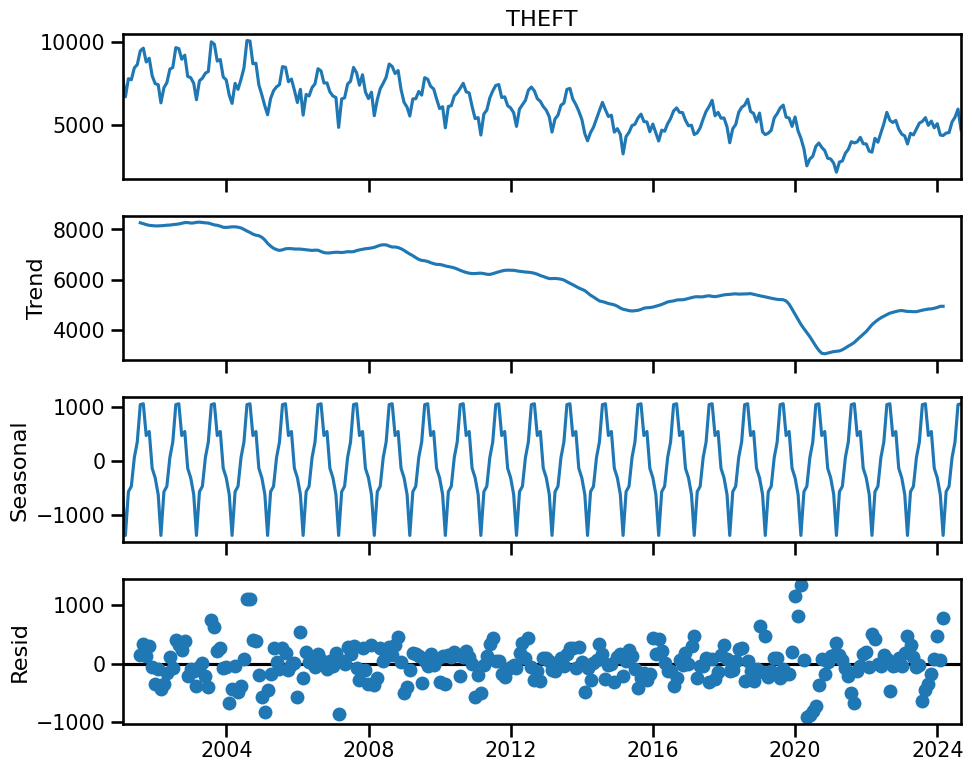

In [31]:
fig = decomp.plot()
fig.set_size_inches(10,8)
fig.tight_layout()

In [33]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()
# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(df_t_m.max()-df_t_m.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 2445.670289855072 which is ~30.78% of the variation in time series.


In [34]:
# determine d
d = ndiffs(df_t_m)
print (f'd = {d}')

d = 1


In [35]:
get_adfuller_results(df_t_m)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-1.385369,13,270,0.58927,0.05,False


In [36]:
ts_diff = df_t_m.diff().dropna()

In [37]:
get_adfuller_results(ts_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-4.202214,12,270,0.000653,0.05,True


In [38]:
# Determine D
D = nsdiffs(df_t_m, m =12)
print(f'D = {D}')

D = 0


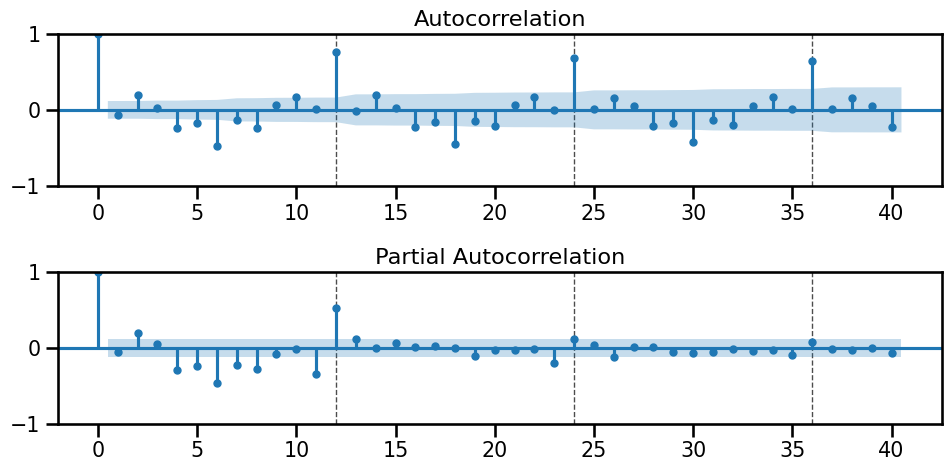

In [39]:
plot_acf_pacf(ts_diff, annotate_seas=True, m = 12);

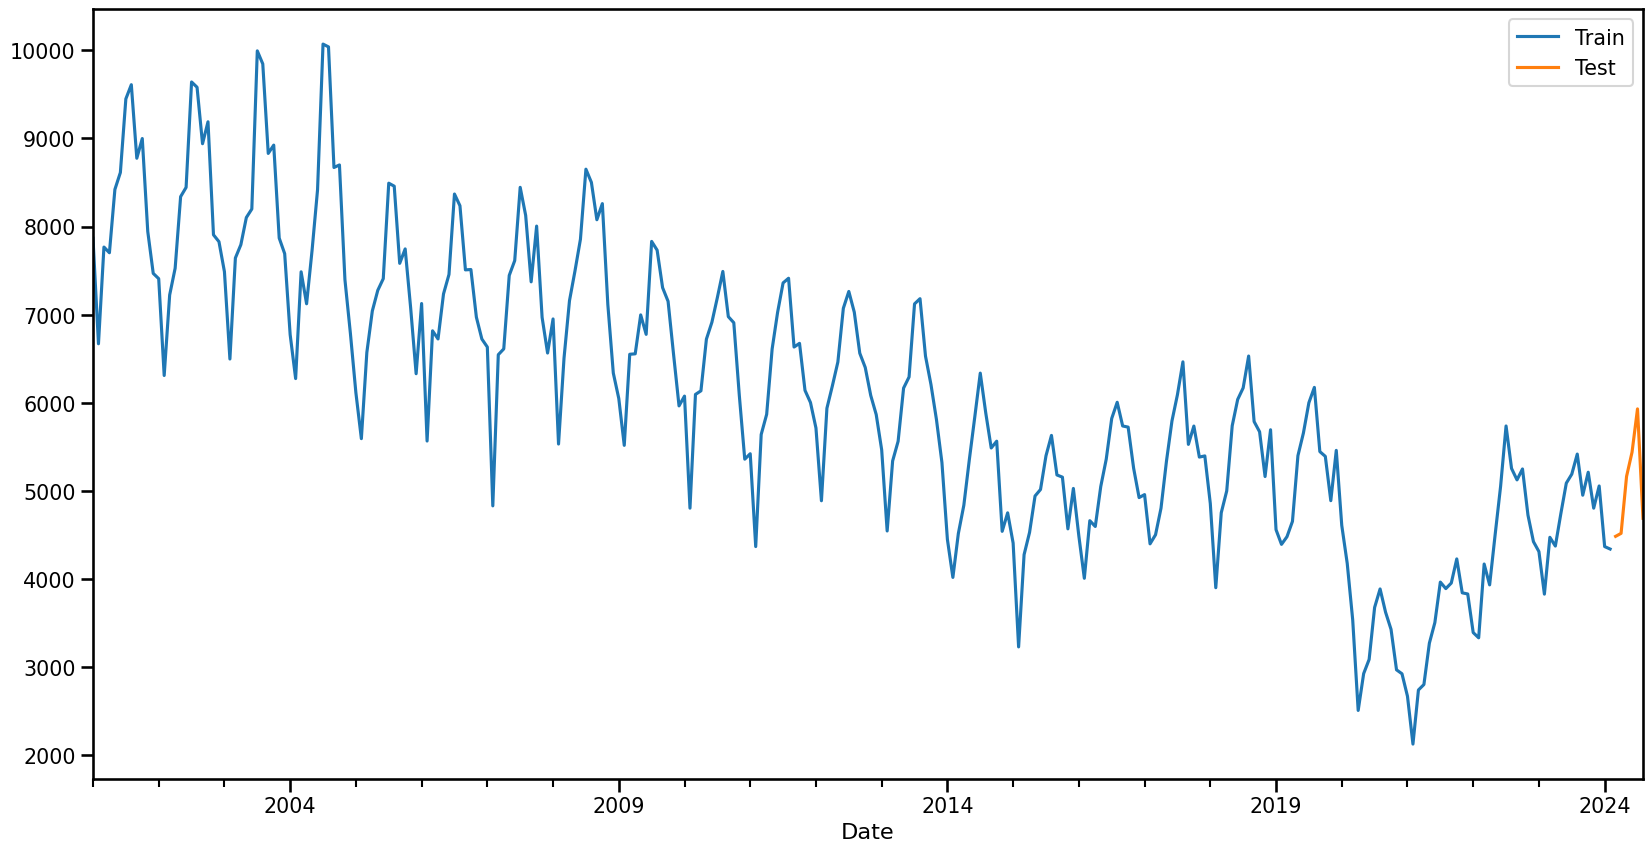

In [41]:
# tts
train, test = train_test_split(df_t_m, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [42]:
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            THEFT   No. Observations:                  278
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2014.523
Date:                          Mon, 23 Sep 2024   AIC                           4039.045
Time:                                  15:07:00   BIC                           4057.166
Sample:                              01-31-2001   HQIC                          4046.316
                                   - 02-29-2024                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9921      0.086     11.521      0.000       0.823       1.161
ma.L1         -0.9991      0.080    -12.430      0.000      -1.157      -0.842
ar.S.L12       0.9787      0.007    144.100      0.000       0.965       0.992
ma.S.L12      -0.6669      0.043    -15.387      0.000      -0.752      -0.582
sigma2      1.118e+05   8089.323     13.822      0.000     9.6e+04    1.28e+05
===================================================================================
Ljung-Box (L1) (Q):                  14.28   Jarque-Bera (JB):                15.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.27
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

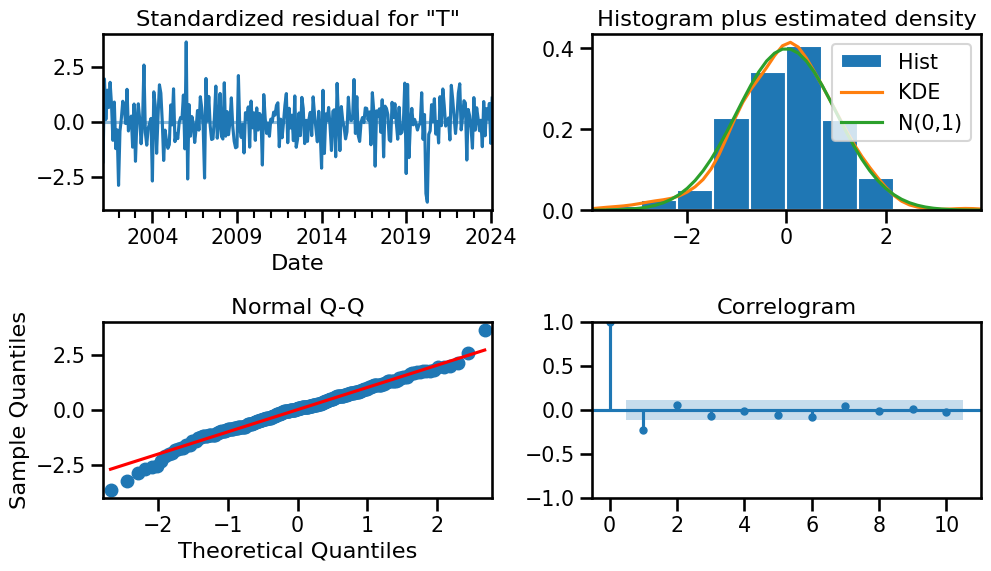

In [43]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

regarding the diagnostics the model is not bad still facing some issues in the residuals and the correlogram

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 302.961
- MSE = 242,648.535
- RMSE = 492.594
- R^2 = 0.130
- MAPE = 6.43%


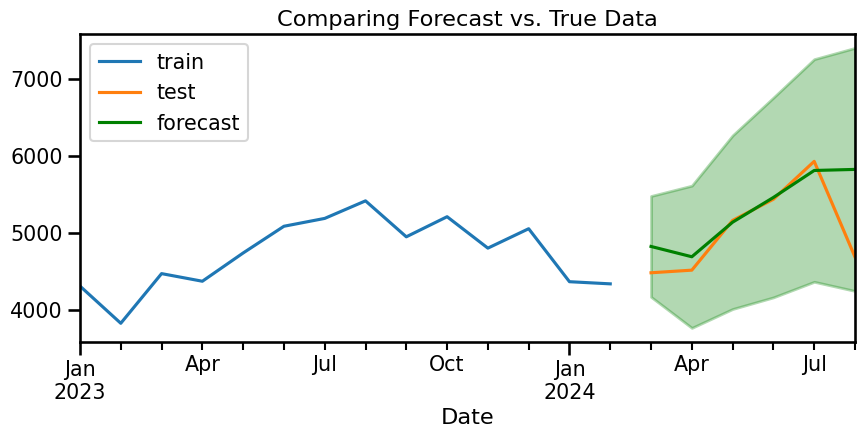

In [46]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train.loc['2023':], test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [58]:
auto_model1 = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4352.770, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4078.002, Time=0.46 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4210.407, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4350.888, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4352.827, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4056.365, Time=1.17 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4023.137, Time=2.82 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4023.368, Time=1.12 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.83 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=4022.444, Time=2.56 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=4161.156, Time=1.12 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4209.223, Time=0.42 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=4037.688, Time=2.50 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [59]:
# Obtain summary of the best model from auto_arima
auto_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  278
Model:             SARIMAX(1, 1, 0)x(1, 0, [1, 2], 12)   Log Likelihood               -2005.395
Date:                                 Mon, 23 Sep 2024   AIC                           4020.791
Time:                                         15:21:20   BIC                           4038.911
Sample:                                     01-31-2001   HQIC                          4028.061
                                          - 02-29-2024                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2410      0.044     -5.473      0.000      -0.327      -0.155
ar.S.L12       0.9786      0.008    129.802      0.000       0.964       0.993
ma.S.L12      -0.5935      0.057    -10.344      0.000      -0.706      -0.481
ma.S.L24      -0.1084      0.066     -1.646      0.100      -0.238       0.021
sigma2      1.007e+05   6844.235     14.713      0.000    8.73e+04    1.14e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                36.90
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                            -0.46
Prob(H) (two-sided):                  0.28   Kurtosis:                         4.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

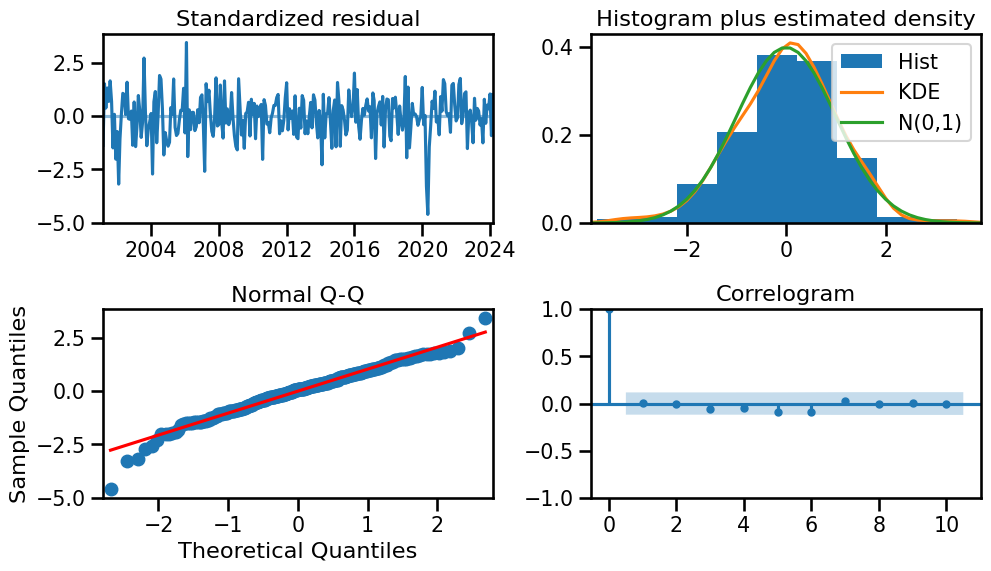

In [61]:
# Obtain diagnostic plots
fig = auto_model1.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

like this model still facing issues regarding the residuals, the other diagnostics graph are better than the baseline model

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 304.076
- MSE = 224,567.314
- RMSE = 473.885
- R^2 = 0.195
- MAPE = 6.34%


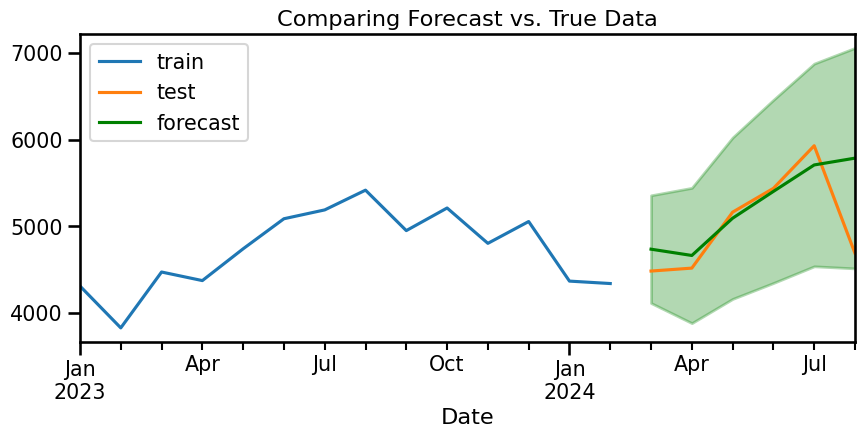

In [62]:
# Use auto_arima parameters to fit an ARIMA
auto_model1 = tsa.ARIMA(
    train, order=auto_model1.order, seasonal_order=auto_model1.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train.loc['2023':], test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

comparing the models this model is doing better regardung the diagnostics,MAPE and r2, would recommend it over the baseline model

In [64]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 2  # Seasonal MA
m = 12 # Seasonal period

final_model = tsa.ARIMA(df_t_m, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

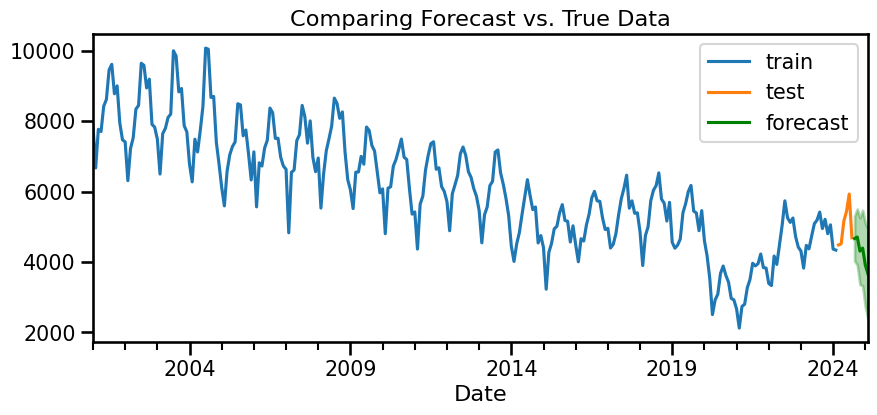

In [65]:
# Obtain future forecasts beyond test data
forecast_df  = final_model.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [66]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2024-09-30 00:00:00'), Timestamp('2025-02-28 00:00:00'))

In [67]:
starting_value = forecast_df['mean'].iloc[0]
starting_value

4666.712830688333

In [68]:
final_value = forecast_df['mean'].iloc[-1]
final_value

3659.2797005134125

In [69]:
change = final_value - starting_value
change

-1007.4331301749207

In [70]:
perc_change = (change / starting_value) * 100
perc_change

-21.587639238267116

## Narcotics

In [71]:
df_n_m = crimes_df['NARCOTICS']

In [72]:
decomp1 = tsa.seasonal_decompose(df_n_m)

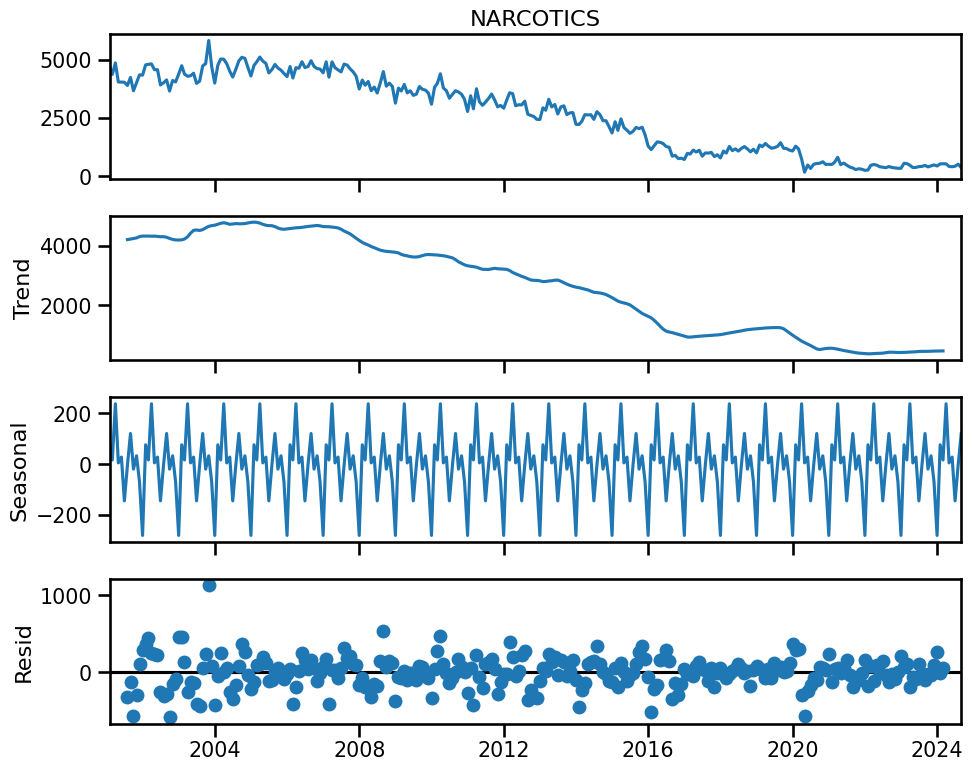

In [73]:
fig = decomp1.plot()
fig.set_size_inches(10,8)
fig.tight_layout()

In [74]:
# How big is the seasonal component
seasonal_delta1 = decomp1.seasonal.max() - decomp1.seasonal.min()
# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta1} which is ~{seasonal_delta1/(df_n_m.max()-df_n_m.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 519.2062747035574 which is ~9.20% of the variation in time series.


In [76]:
# determine d
d = ndiffs(df_n_m)
print (f'd = {d}')

d = 1


In [77]:
get_adfuller_results(df_n_m)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-0.095766,12,271,0.949859,0.05,False


In [78]:
ts_diff1 = df_n_m.diff().dropna()

In [79]:
get_adfuller_results(ts_diff1)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-5.539987,11,271,0.000002,0.05,True


In [80]:
# Determine D
D = nsdiffs(df_n_m, m =12)
print(f'D = {D}')

D = 0


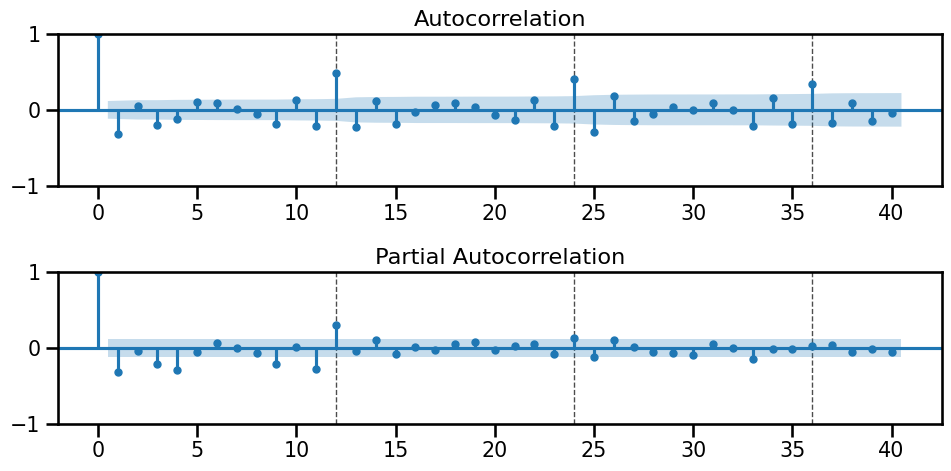

In [81]:
plot_acf_pacf(ts_diff1, annotate_seas=True, m = 12);

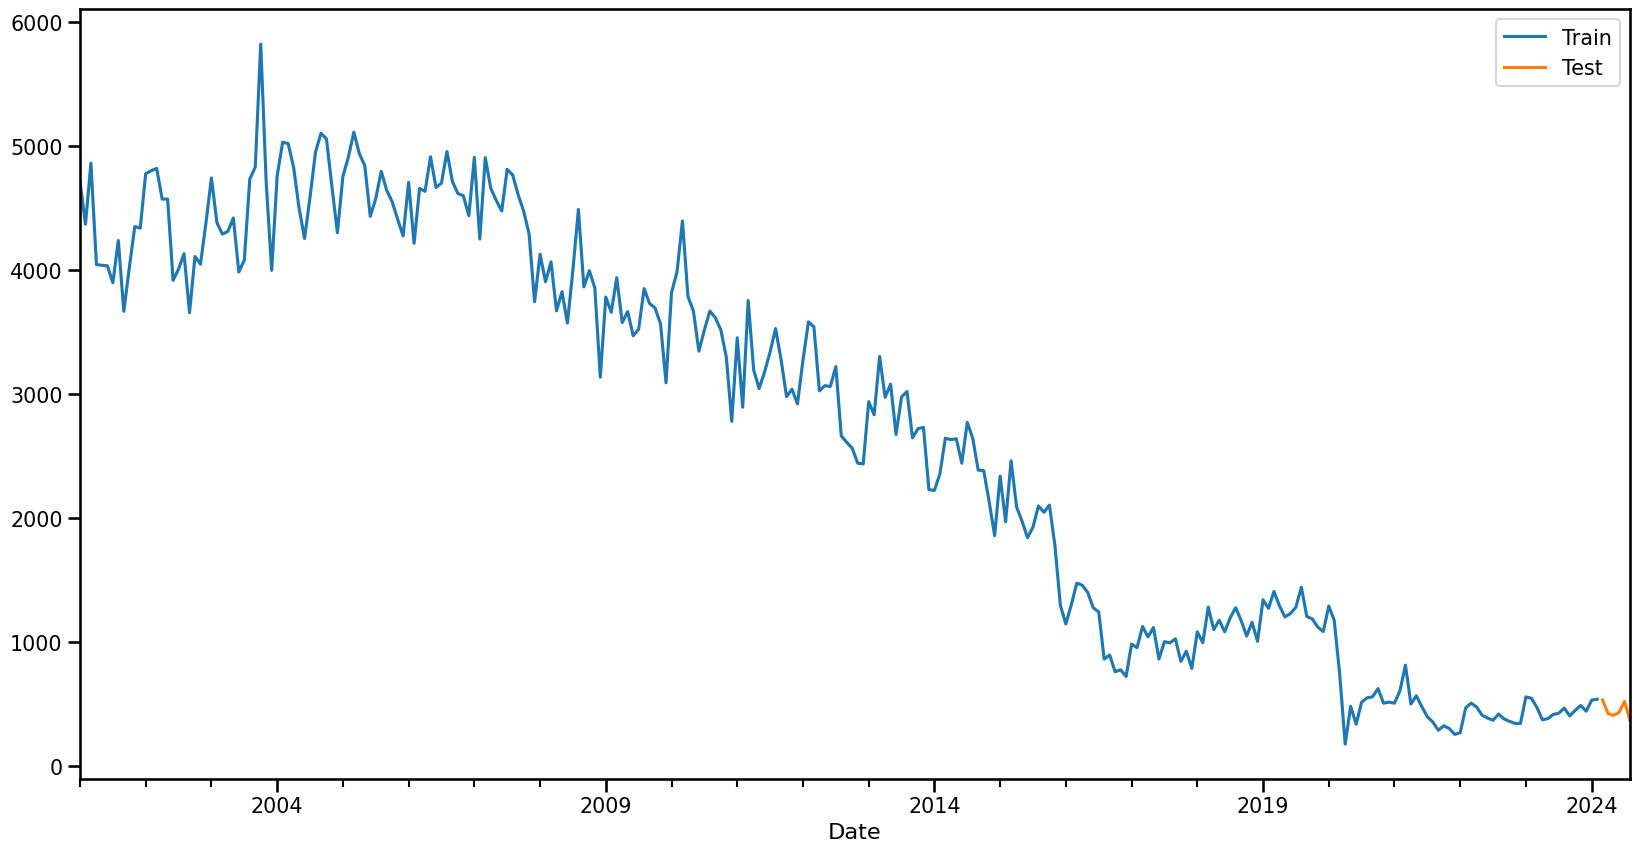

In [82]:
train, test = train_test_split(df_n_m, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [83]:
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima1 = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        NARCOTICS   No. Observations:                  278
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1893.015
Date:                          Mon, 23 Sep 2024   AIC                           3796.030
Time:                                  15:37:56   BIC                           3814.150
Sample:                              01-31-2001   HQIC                          3803.301
                                   - 02-29-2024                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5569      0.081      6.916      0.000       0.399       0.715
ma.L1         -0.8325      0.064    -13.103      0.000      -0.957      -0.708
ar.S.L12       0.9444      0.026     36.116      0.000       0.893       0.996
ma.S.L12      -0.7245      0.072    -10.115      0.000      -0.865      -0.584
sigma2      4.952e+04   3025.686     16.368      0.000    4.36e+04    5.55e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                66.38
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

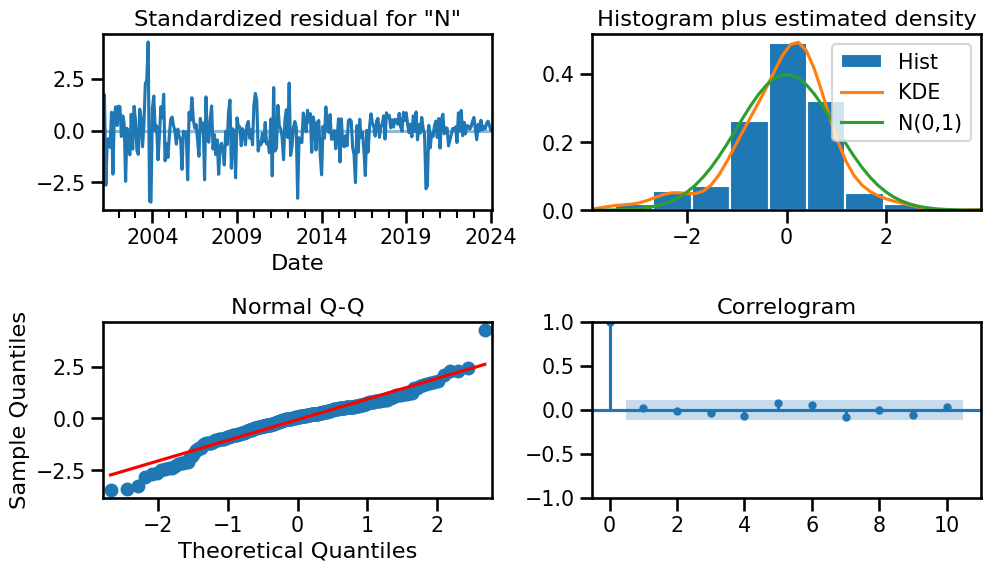

In [84]:
# Obtain diagnostic plots
fig = sarima1.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

observing the model diagnostics there's an issue with the residuals and normal q-q at the beginning

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 47.927
- MSE = 3,871.181
- RMSE = 62.219
- R^2 = -0.095
- MAPE = 10.41%


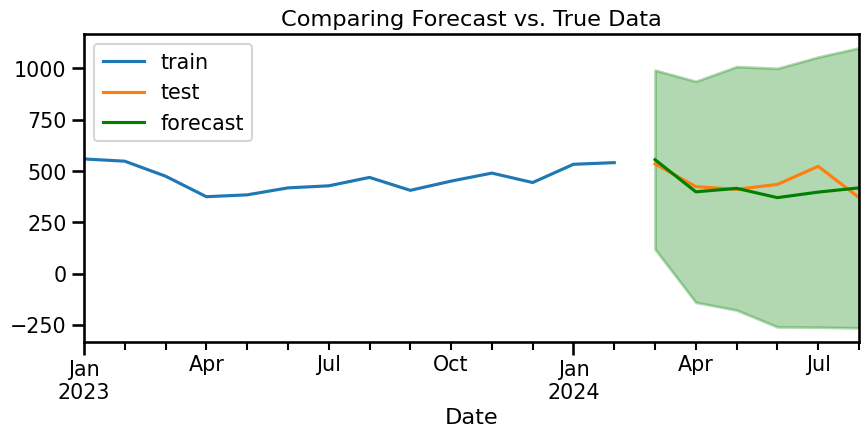

In [86]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima1.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train.loc['2023':], test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

In [87]:
auto_model2 = pm.auto_arima(
    train,
    seasonal=True,  
    m=12,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3934.597, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3843.001, Time=0.74 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3855.809, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3933.334, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3906.904, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3835.623, Time=1.44 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=3818.228, Time=3.54 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3816.080, Time=1.10 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3863.328, Time=0.42 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=3815.848, Time=3.49 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=3849.924, Time=1.12 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.38 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=3823.690, Time=2.35 sec
 ARIMA(2,1,0)(1,0,2)[12] inte

In [88]:
auto_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  278
Model:             SARIMAX(4, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1892.045
Date:                              Mon, 23 Sep 2024   AIC                           3798.091
Time:                                      15:51:40   BIC                           3823.459
Sample:                                  01-31-2001   HQIC                          3808.269
                                       - 02-29-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2518      0.039     -6.423      0.000      -0.329      -0.175
ar.L2         -0.1871      0.049     -3.802      0.000      -0.283      -0.091
ar.L3         -0.2037      0.054     -3.746      0.000      -0.310      -0.097
ar.L4         -0.1960      0.057     -3.468      0.001      -0.307      -0.085
ar.S.L12       0.9359      0.030     31.250      0.000       0.877       0.995
ma.S.L12      -0.7124      0.076     -9.427      0.000      -0.860      -0.564
sigma2      4.937e+04   3168.648     15.581      0.000    4.32e+04    5.56e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                57.70
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

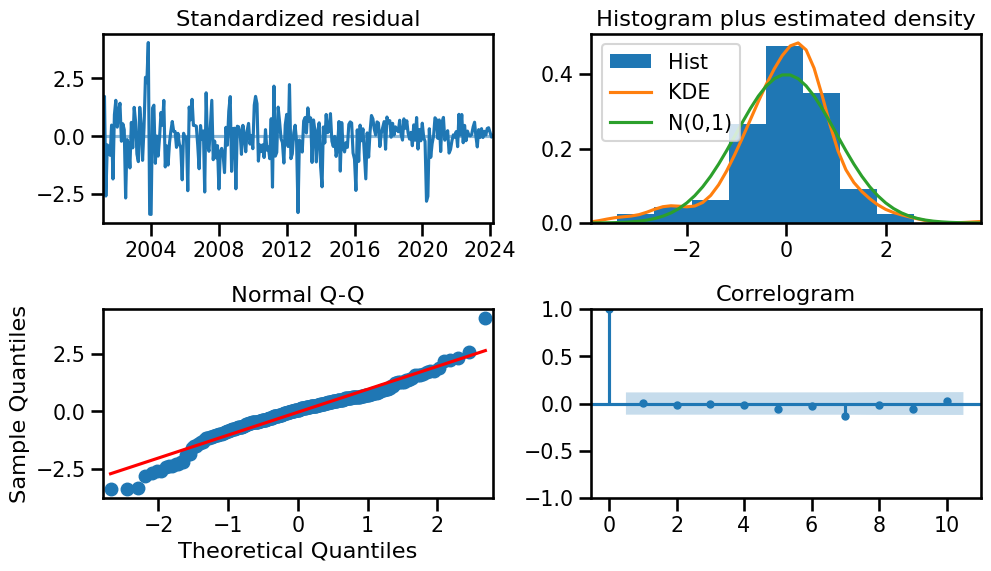

In [89]:
# Obtain diagnostic plots
fig = auto_model2.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

still this model is facing the same issues as the baseline model regaridng the diagnostics

C:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 44.296
- MSE = 2,969.077
- RMSE = 54.489
- R^2 = 0.160
- MAPE = 10.18%


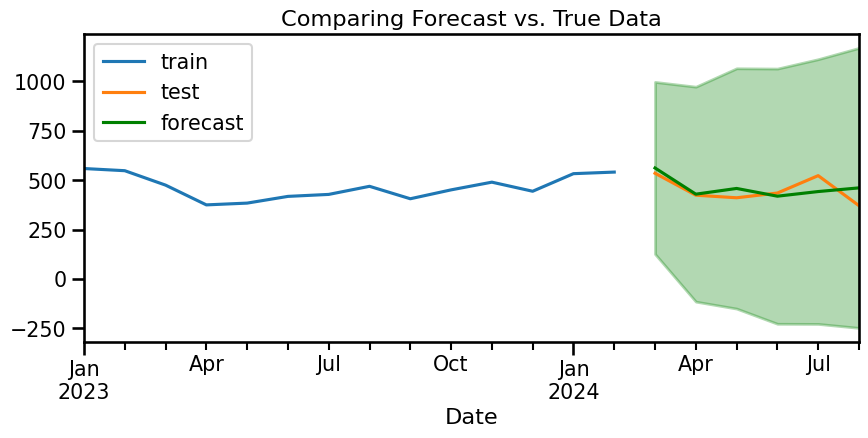

In [90]:
# Use auto_arima parameters to fit an ARIMA
auto_model2 = tsa.ARIMA(
    train, order=auto_model2.order, seasonal_order=auto_model2.seasonal_order
).fit()


# Obtain forecast as a dataframe with confidence intervals
forecast_df = auto_model2.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train.loc['2023':], test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

between the two models will choose the second model because it has lower MAE and MAPE, also higer R2 but it needs 4 lags to predict but overall its better than the baseline model

In [91]:
# These are the parameters of our final model
# Orders for non seasonal components
p = 4  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

final_model1 = tsa.ARIMA(df_n_m, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

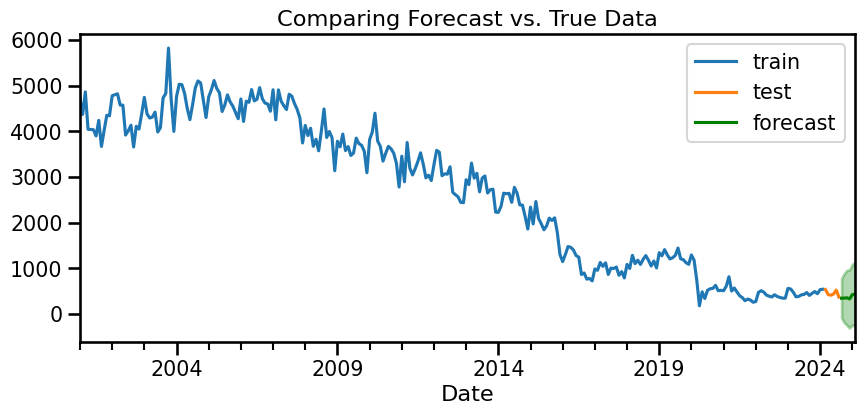

In [92]:
# Obtain future forecasts beyond test data
forecast_df  = final_model1.get_forecast(len(test)).summary_frame()
plot_forecast(train,test,forecast_df);

In [93]:
forecast_df.index[0],forecast_df.index[-1]

(Timestamp('2024-09-30 00:00:00'), Timestamp('2025-02-28 00:00:00'))

In [94]:
starting_value = forecast_df['mean'].iloc[0]
starting_value

344.3373893623781

In [95]:
final_value = forecast_df['mean'].iloc[-1]
final_value

433.6002712885279

In [96]:
change = final_value - starting_value
change

89.26288192614982

In [97]:
perc_change = (change / starting_value) * 100
perc_change

25.923087263756372

### Final Evaluation:
After completing both models and getting the forecasts for both crimes for 6 months into the future (beyond the data), answer the following questions in a Markdown cell:

- Of the two crimes, which is forecasted to have the highest monthly count of crimes at the end of the forecast?
    - Theft
- Of the two crimes, which is forecasted to have the highest net change by the end of the forecast?
    - Theft
- Of the two crimes, which is forecasted to have the highest percent change by the end of the forecast?
    - Narcotics

### Final Recommendations
- What recommendation would you make to the stakeholders?
    - that there should be a raise of the size of the DEA department in Chicago also should make the narcotics violations more strict in order for the crime rate decrease not increase like it will do